In [2]:
# Look at the fluxes as recorded in the average files
import os
import pandas as pd
import xarray as xr
import numpy as np
from stompy import utils
import six
import matplotlib.gridspec as gridspec
from stompy import filters
import matplotlib.pyplot as plt
%matplotlib notebook

from stompy.io.local import noaa_coops
from stompy.grid import unstructured_grid
from stompy.model.suntans import sun_driver

In [3]:
#modelA=sun_driver.SuntansModel.load("/opt/sfb_ocean/suntans/runs/merge_005-20170610avg-retry/")
# really thought this one was going to fix things:
modelA=sun_driver.SuntansModel.load("/opt/sfb_ocean/suntans/runs/merge_006-20170610/")
modelA.projection="EPSG:26910"

INFO:DFlowModel:Will read cell depths, too
INFO:DFlowModel:Will read edge depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [4]:
avg=xr.open_dataset(modelA.avg_outputs()[0])

In [5]:
g=unstructured_grid.UnstructuredGrid.from_ugrid(avg)

<IPython.core.display.Javascript object>


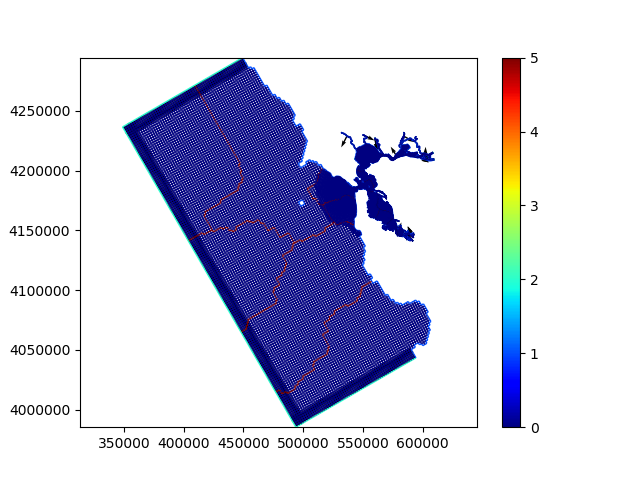

In [6]:
# First, sum over all open boundaries, make sure at least that much agrees with
# the change in volume.
plt.figure()
sel=(avg.mark.values==2)
coll=g.plot_edges(values=avg.mark,lw=1,cmap='jet')
plt.colorbar(coll)

plt.quiver(avg.xe.values[sel],avg.ye.values[sel],
           avg.n1.values[sel],avg.n2.values[sel])
# make sure the normals make sense:
# normals are positive IN, for all flows BCs.
# that makes sense with the suntans convention -
#  internal cell is always first, and normals are positive
#  towards first cell.

# internal: 0
# land: 1
# velocity: 2
# interproc: 5

In [7]:
sel=(avg.mark.values==2)
None

In [20]:
# looking for faster ways of getting the flux data.
UF=avg.U_F
# 20GB...
#480*50*108448*8 / 1e9
UF # time, Nk, Ne
UF['Ne']=('Ne',),np.arange(avg.dims['Ne'])
UF['Nk']=('Nk',),np.arange(avg.dims['Nk'])

# 2.5s per edge when extracting one edge at a time.
# way faster to load all of each time step, grab
# the edges I want, and copy.
UFparts=[]
        
for ti in utils.progress(np.arange(avg.dims['time'])):
    part=UF.isel(time=ti).copy()
    part=part.isel(Ne=sel).copy()
    UFparts.append(part)

INFO:utils:54/480
INFO:utils:108/480
INFO:utils:162/480
INFO:utils:216/480
INFO:utils:270/480
INFO:utils:323/480
INFO:utils:376/480
INFO:utils:429/480


In [23]:
UFsel=xr.concat(UFparts,dim='time')
UFsel

<xarray.DataArray 'U_F' (time: 480, Nk: 50, Ne: 296)>
array([[[          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       [[          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       ...,

       [[ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 3.952749e-02,  5.844202e+01, ...,  1.411456e+00, -7.252068e+01],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,       

In [24]:
Q_in=[]
for ti in utils.progress(range(len(avg.time))):
    Q_in.append(UFsel.isel(time=ti).sum(dim='Ne').sum(dim='Nk'))

In [25]:
dt_s=np.median(np.diff(avg.time.values-avg.time.values[0])/np.timedelta64(1,'s'))
dt_s

1800.0

In [27]:
total_A=g.boundary_polygon().area

INFO:join_features:0 open strings, 20 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38248243973.344292, 19 potential interiors


<IPython.core.display.Javascript object>


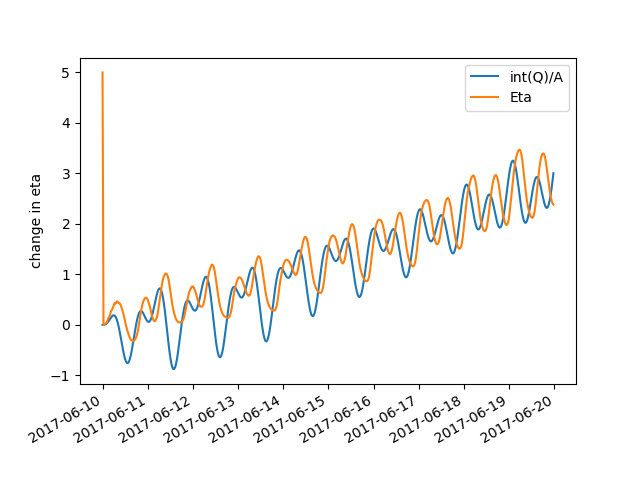

In [28]:
plt.figure()
plt.plot(avg.time,np.cumsum(Q_in)*dt_s/total_A,label='int(Q)/A')
plt.plot(avg.time,5+avg.eta.isel(Nc=4000),label='Eta')
plt.ylabel("change in eta")
plt.legend()
plt.gcf().autofmt_xdate()
None

In [29]:
# Start dissecting the bc inputs:
modelA.load_bc_ds()

In [30]:
modelA.bc_ds

<xarray.Dataset>
Dimensions:      (Nk: 50, Npoint: 3, Nseg: 15, Nt: 7350, Ntype2: 296, Ntype3: 0)
Dimensions without coordinates: Nk, Npoint, Nseg, Nt, Ntype2, Ntype3
Data variables:
    z            (Nk) float64 ...
    time         (Nt) datetime64[ns] ...
    cellp        (Ntype3) int32 ...
    xv           (Ntype3) float64 ...
    yv           (Ntype3) float64 ...
    uc           (Nt, Nk, Ntype3) float64 ...
    vc           (Nt, Nk, Ntype3) float64 ...
    wc           (Nt, Nk, Ntype3) float64 ...
    T            (Nt, Nk, Ntype3) float64 ...
    S            (Nt, Nk, Ntype3) float64 ...
    h            (Nt, Ntype3) float64 ...
    edgep        (Ntype2) int32 ...
    xe           (Ntype2) float64 ...
    ye           (Ntype2) float64 ...
    boundary_h   (Nt, Ntype2) float64 ...
    boundary_u   (Nt, Nk, Ntype2) float64 ...
    boundary_v   (Nt, Nk, Ntype2) float64 ...
    boundary_w   (Nt, Nk, Ntype2) float64 ...
    boundary_T   (Nt, Nk, Ntype2) float64 ...
    boundary_S   (Nt

In [31]:
bc_ds=modelA.bc_ds

xe=bc_ds.xe
ye=bc_ds.ye
xye=np.c_[xe,ye]

type2_edges=[]
for xy in xye:
    type2_edges.append(g.select_edges_nearest(xy))
type2_edges=np.array(type2_edges)    

In [32]:
assert len(type2_edges)==len(np.unique(type2_edges)),"duplicate edges"

ec=g.edges_center()
errs=utils.dist( ec[type2_edges] - xye )
assert np.all(errs<1e-3),"edge center match is not good"

In [33]:
# is there a mismatch in the layers?  baseline is pretty good.
layers=modelA.layer_data(with_offset=True)
vertspace=np.loadtxt(os.path.join(modelA.run_dir,'vertspace.dat'))
dz=-np.diff(layers.z_interface)
assert np.all( np.abs(dz-vertspace)<1e-3),"Layer model is off"

In [34]:
# nominal depth of each edge:
type2_depths=modelA.grid.edges['edge_depth'][type2_edges]

# make sure no reordering occurred
assert np.allclose( modelA.grid.edges_center(), ec ),"grids don't match"


In [52]:
# bc_ds has boundary_u,boundary_v
# so just need to populate dzf[Nk,Ntype2]
dzf=np.zeros( (bc_ds.dims['Nk'],bc_ds.dims['Ntype2']),np.float64)
# if 0, avg Q and BC net flux agree after ramp
# if -5 as it 'should' be, bc net flux is actually even worse.
eta=0 

for type2_idx,j in enumerate(type2_edges):
    z_int=(-layers.z_interface.values).clip(-eta,-type2_depths[type2_idx])
    dzf[:,type2_idx]=np.diff(z_int)
assert np.all(dzf>=0.0)    

In [53]:
bc_ds['dzf']=('Nk','Ntype2'),dzf
bc_ds['L']=('Ntype2',),g.edges_length()[type2_edges]
bc_ds['n1']=('Ntype2',),avg.n1.values[type2_edges]
bc_ds['n2']=('Ntype2',),avg.n2.values[type2_edges]

In [54]:
bc_sel=(bc_ds.time>=avg.time.values[0])&(bc_ds.time<=avg.time.values[-1])
snap=bc_ds.isel(Nt=bc_sel)
fluxA=snap.dzf*snap.L
fluxUnorm=snap.n1*snap.boundary_u + snap.n2*snap.boundary_v
snap_flux=fluxA*fluxUnorm
snap_flux_net=snap_flux.sum(dim='Nk').sum(dim='Ntype2')
snap_flux_net
Nke=np.searchsorted(-layers.z_interface.values,-type2_depths)

In [55]:
snap_dt=np.median(np.diff(snap.time.values)/np.timedelta64(1,'s'))
avg_dt=np.median(np.diff(avg.time.values)/np.timedelta64(1,'s'))

<IPython.core.display.Javascript object>


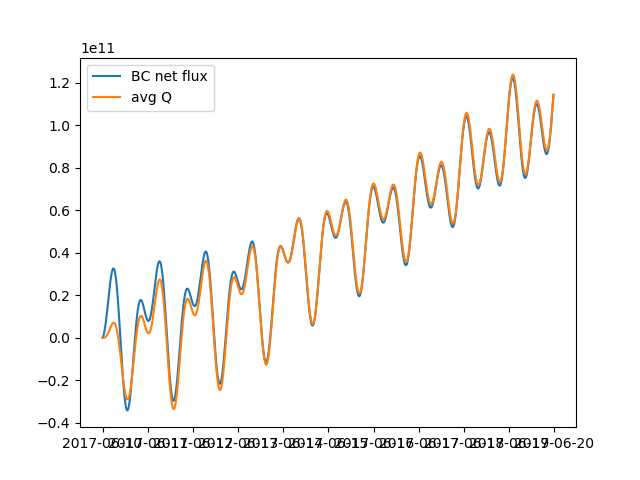

In [56]:
plt.figure()

plt.plot(snap.time,np.cumsum(snap_flux_net.values)*snap_dt,label='BC net flux')
plt.plot(avg.time,np.cumsum(Q_in)*avg_dt,label='avg Q')
plt.legend()

In [ ]:
# snap_flux = fluxA*fluxUnorm
# 0: has a lot of tidal action, but also pretty deep.
#    weird.
# 146: smaller range, but same sort of pattern.
#   both of these look upside down - with larger magnitude
#   and more tidal variation at high k.
# 
type2_idx=146 # westernmost type2 edge
#type2_idx=250 # edge with Nke=20

j=type2_edges[type2_idx]

edge_bc_fluxes =snap_flux.isel(Ntype2=type2_idx)

edge_avg_fluxes=avg.U_F.isel(Ne=j)

In [ ]:
edge_bc_fluxes.shape # Nk,Nt
edge_bc_fluxes_30min=edge_bc_fluxes[:,::2] # start simple

In [ ]:
fig,axs=plt.subplots(3,1,sharex=True,sharey=True)

# plot their difference
img2=axs[2].pcolormesh(avg.time,np.arange(avg.dims['Nk']),
                       edge_avg_fluxes.T.values -  edge_bc_fluxes_30min.values,
                       cmap='seismic')

img0=axs[0].pcolormesh(snap.time,snap_flux.Nk,edge_bc_fluxes,cmap='seismic')
img1=axs[1].pcolormesh(avg.time,np.arange(avg.dims['Nk']),
                       edge_avg_fluxes.T,cmap='seismic')

plt.setp([img0,img1],clim=[-1e5,1e5])
plt.setp(img2,clim=[-1e4,1e4])

# These are flux into the domain.  so this ramp up period reflects that this edge
# should have a fair bit of flow out of the domain, but misses that during the ramp
# up.
plt.colorbar(img0,ax=axs[0])
plt.colorbar(img1,ax=axs[1])
plt.colorbar(img2,ax=axs[2])

axs[0].set_title("type2_idx=%d j=%d de=%.1f Nke=%d"%(type2_idx,j,-type2_depths[type2_idx],Nke[type2_idx]))



In [ ]:
# Similar - but cumulative for each layer.
fig,axs=plt.subplots(3,1,sharex=True,sharey=True)

# plot their difference
delta=edge_avg_fluxes.T.values -  edge_bc_fluxes_30min.values
delta[np.isnan(delta)]=0
img2=axs[2].pcolormesh(avg.time,np.arange(avg.dims['Nk']),
                       np.cumsum(delta,axis=1),
                       cmap='seismic')

img0=axs[0].pcolormesh(snap.time,snap_flux.Nk,edge_bc_fluxes,cmap='seismic')
img1=axs[1].pcolormesh(avg.time,np.arange(avg.dims['Nk']),
                       edge_avg_fluxes.T,cmap='seismic')

plt.setp([img0,img1],clim=[-1e5,1e5])
plt.setp(img2,clim=[0,1e6])
img2.set_cmap('jet')

# These are flux into the domain.  so this ramp up period reflects that this edge
# should have a fair bit of flow out of the domain, but misses that during the ramp
# up.
plt.colorbar(img0,ax=axs[0])
plt.colorbar(img1,ax=axs[1])
plt.colorbar(img2,ax=axs[2])

axs[0].set_title("type2_idx=%d j=%d de=%.1f Nke=%d"%(type2_idx,j,-type2_depths[type2_idx],Nke[type2_idx]))


In [ ]:
# sum the average fluxes just by edge, to get a sense of whether there is a spatial bias of who is causing issues.
Qh_in={} # now each of these will be a single edge over time, mapping from j

In [ ]:
fig=plt.figure(figsize=(10,10))

def update_plot():
    fig.clf()
    ax=fig.add_subplot(2,1,1)
    ax_map=fig.add_subplot(2,1,2)
    
    net=0.0
    j_list=list(Qh_in.keys())
    net_per_j=[]
    
    for jj in j_list:
        da=Qh_in[jj]
        
        #ax.plot(avg.time.values,np.cumsum(da.values))
        # Rather than the absolute flux, plot how it compares to what
        # we expect:
        # Find the matching bc:
        typ2_i=np.nonzero(type2_edges==jj)[0][0]
        snap_Q=snap_flux.isel(Ntype2=typ2_i).sum(dim='Nk').values
        error=da.values-snap_Q[::2]
        net=net+error
        ax.plot(avg.time.values,
                np.cumsum(error)*avg_dt/total_A)
        net_per_j.append(np.sum(error)*avg_dt/total_A)
        
    ax.plot(avg.time.values,np.cumsum(net)*avg_dt/total_A,lw=5,color='k',alpha=0.5)

    ax.set_title('%d edges'%len(Qh_in))
    
    ax_map.cla()
    ecoll=g.plot_edges(ax=ax_map,mask=j_list,values=net_per_j,cmap='seismic',lw=1.25)
    g.plot_edges(ax=ax_map,color='0.8',lw=0.2,zorder=-1)
    scale=np.abs(net_per_j).max()
    ecoll.set_clim([-scale,scale])
    plt.colorbar(ecoll,ax=ax_map)
    ax_map.axis(g.bounds())
    fig.canvas.draw()
    plt.pause(0.1)
update_plot()

In [ ]:

update_plot()
for type2_index,j in enumerate(type2_edges):
    if j in Qh_in: continue
        
    Qe_in=avg.U_F.isel(Ne=j).sum(dim='Nk')
    Qh_in[j]=Qe_in
    update_plot()
    

In [ ]:
# so far the non-tidal ones show that over the ramp-up time
# there is not as much water going in as we'd expect, but
# afterwards it's about right.

In [57]:
Qv_in={}

<IPython.core.display.Javascript object>


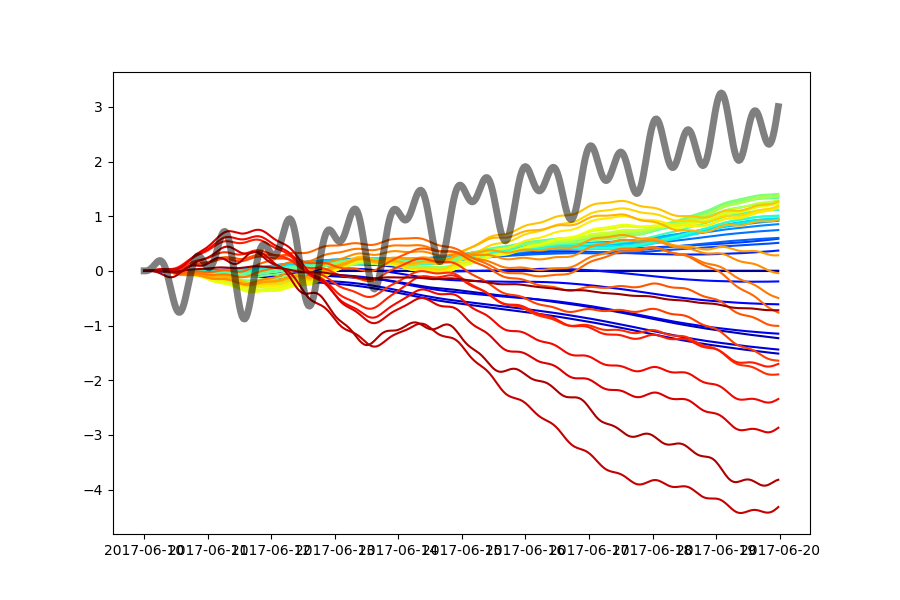

In [65]:
figk=plt.figure(figsize=(9,6))

from matplotlib import cm

def update_k_plot():
    figk.clf()
    ax=figk.add_subplot(1,1,1)
    
    net=0.0
    k_list=list(Qv_in.keys())
    net_per_k=[]
    
    for kk in k_list:
        da=Qv_in[kk]
        snap_Q=snap_flux.isel(Nk=kk).sum(dim='Ntype2').values
        error=da.values # -snap_Q[::2]
        net=net+error
        ax.plot(avg.time.values,
                np.cumsum(error)*avg_dt/total_A,
                color=cm.jet(float(kk)/avg.dims['Nk']))
        net_per_k.append(np.sum(error)*avg_dt/total_A)

    if len(k_list)>0:
        ax.plot(avg.time.values,np.cumsum(net)*avg_dt/total_A,lw=5,color='k',alpha=0.5)

    figk.canvas.draw()
    plt.pause(0.1)
update_k_plot()

In [60]:
UFsel

<xarray.DataArray 'U_F' (time: 480, Nk: 50, Ne: 296)>
array([[[          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       [[          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       ...,

       [[ 0.000000e+00,  0.000000e+00, ...,  0.000000e+00,  0.000000e+00],
        [ 3.952749e-02,  5.844202e+01, ...,  1.411456e+00, -7.252068e+01],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,       

In [61]:
# similar but for layers

for k in range(avg.dims['Nk']):
    if k in Qv_in: continue
        
    # check this:
    #Qe_in=UFdata[:,k,:][:,sel].sum(axis=1)
    #Qe_in=UF.U_F.isel(Nk=k,Ne=sel).sum(dim='Ne')
    Qe_in=UFsel.isel(Nk=k).sum(dim='Ne')
    Qv_in[k]=Qe_in
    update_k_plot()
    

In [64]:
Qv_in[0].sum()/

<xarray.DataArray 'U_F' ()>
array(-5.466441)
Coordinates:
    z_r      float64 0.8713
    Nk       int64 0